In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt

import jd

from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,OneHotEncoder,TargetEncoder
from category_encoders import CountEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from imblearn.over_sampling import RandomOverSampler
from feature_engine.encoding import OrdinalEncoder as feat_eng_OrdinalCategoricalEncoder


import warnings
warnings.filterwarnings("ignore")

# EL profesor Luis Gascó de Text Mining me recomendó que los datos que presentan imbalances fuertes, sean gráficamente representados luego de ser pasados por una técnica de remuestreo, eso hago en este notebook.

In [2]:
def preprocess(X,drop=False,X_test = None):
    """
    pasa X_test sólo al preprocesar X
    """
    if X_test is not None:
        cols_mas_unique_en_train = ["subvillage","installer","funder","scheme_name","wpt_name",
                                    "region_code","ward","extraction_type"]
        for i in cols_mas_unique_en_train:
            unicos_en_test = X_test[i].unique().tolist()
            X[i] = [x if x in unicos_en_test else np.nan for x in X[i].values]
            #X[i] = [x if x in unicos_en_test else x.split(" ")[0] for x in X[i].values]



    #Fechas------------------------------------------------------------------------ 
    X.date_recorded = X.date_recorded.astype("O")
    X.date_recorded = pd.to_datetime(X.date_recorded)
    X['date_recorded'] = (X.date_recorded.max() - X.date_recorded).dt.days

    #Marcar VALORES sin sentido como nan para ser imputados------------------------------------------------------------------------  
    X["construction_year"] = X.construction_year.max()-X.construction_year
    X.loc[X["construction_year"] ==2013,"construction_year"] = X.construction_year.mean() # si da 2013 la resta fue max - cero
    #X.construction_year = X.construction_year.fillna(X.construction_year.mean()) 
    #Drop list ------------------------------------------------------------------------ 

    drop_list  = ["management_group","num_private","recorded_by","region","region_code",
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source_class","source_type","waterpoint_type_group",
              "permit","population","amount_tsh"]  
    X.drop(drop_list,axis=1,inplace=True)
    #Clusters de latitud y longitud, se hace fuera para que X_test sea transform sin fit------------------------------------------------------------------------
    #clustering = KMeans(n_clusters=20)
    #X["location_cluster"] = clustering.fit_predict(X[["latitude","longitude"]].to_numpy())
    
    return X

In [3]:
X = pd.read_csv("In/Training_set_values.csv")
y = pd.read_csv("In/Training_set_labels.csv")
X_test = pd.read_csv("In/Test_set_values.csv")



le= LabelEncoder()
#y["status_group"] = le.fit_transform(y.status_group)


X_test = preprocess(X_test)
X = preprocess(X,X_test)
X = X.fillna("Missing")

for i in X.select_dtypes(include = "O").columns:
    X[i] = X[i].astype("category")

## Me doy cuenta ahora que en todo el ejercicio no había hecho ninguna matriz cramer de asociación de variables, en verdad poco uso tiene sabiendo que el random forest es perfectamente tolerante a la multicolinearidad

<AxesSubplot: >

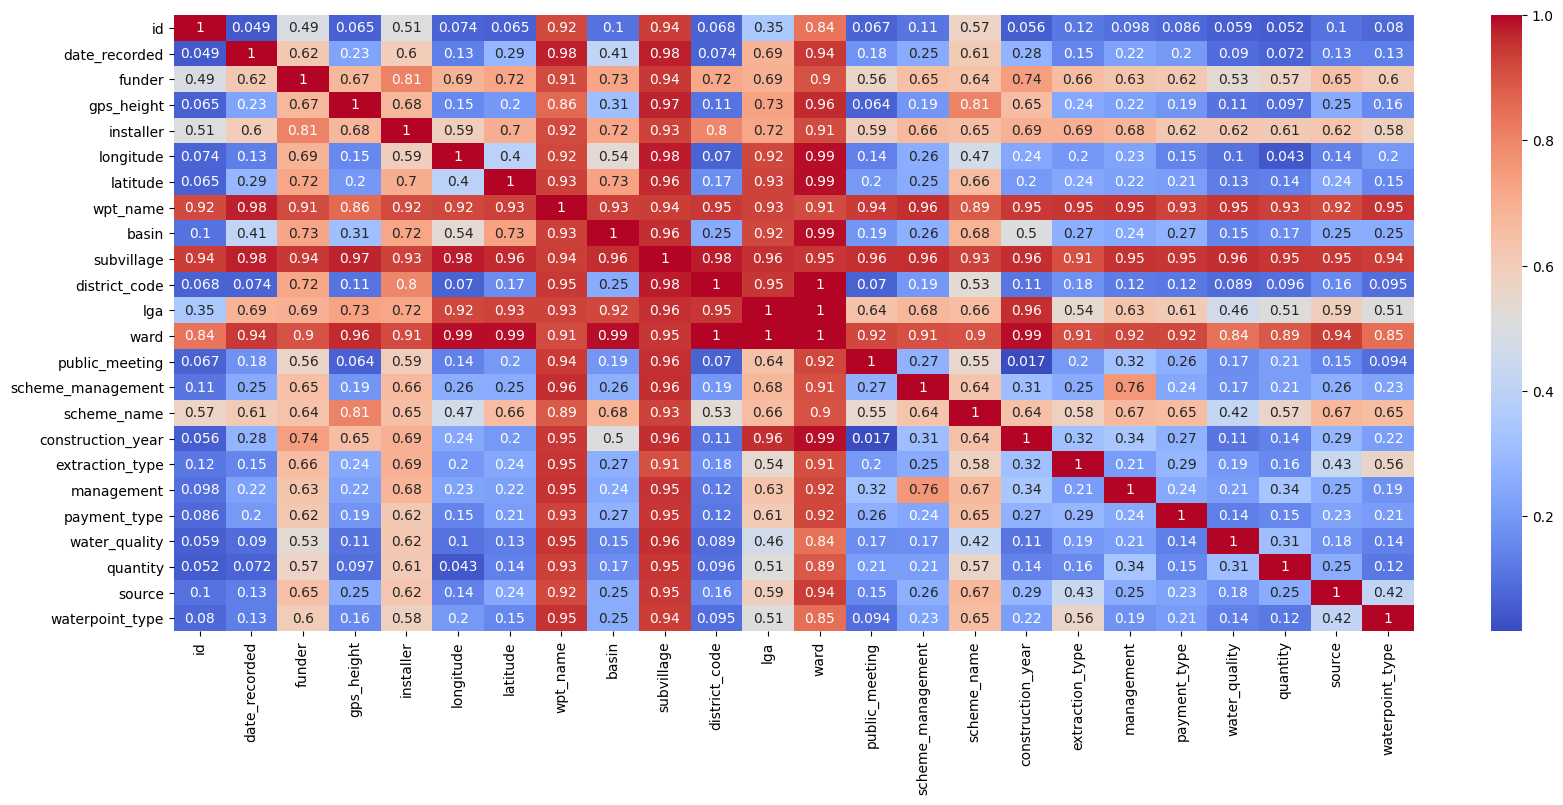

In [4]:
plt.figure(figsize=(20, 8))
mat = jd.get_cat_corr_mat(X.sample(1000))
sns.heatmap(mat,cmap="coolwarm",annot=True)

In [5]:
[x for x in X.columns if x not in X.select_dtypes(exclude=np.number).columns.tolist()]

['id',
 'date_recorded',
 'gps_height',
 'longitude',
 'latitude',
 'district_code',
 'construction_year']

In [6]:
X.select_dtypes(exclude=np.number).columns.tolist()

['funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'lga',
 'ward',
 'public_meeting',
 'scheme_management',
 'scheme_name',
 'extraction_type',
 'management',
 'payment_type',
 'water_quality',
 'quantity',
 'source',
 'waterpoint_type']

In [7]:
y.status_group
lista_cats=X.select_dtypes(include="category").columns.tolist()
X.drop("id",axis=1,inplace=True)

In [8]:
X,y = RandomOverSampler(sampling_strategy = "all").fit_resample(X,y.status_group)

In [9]:
df = X.copy()
df["status_group"] = y

<AxesSubplot: >

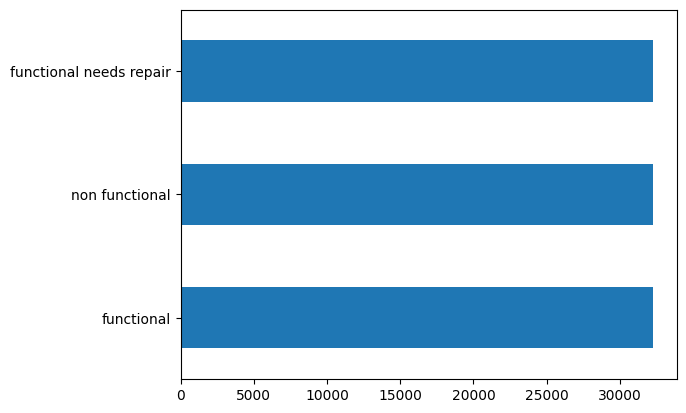

In [10]:
pd.Series(y).value_counts().plot(kind="barh")

In [11]:
for col in X.columns:
    if (X[col].nunique() < 25) and (X[col].nunique() > 3):
        print(col)

basin
district_code
scheme_management
extraction_type
management
payment_type
water_quality
quantity
source
waterpoint_type


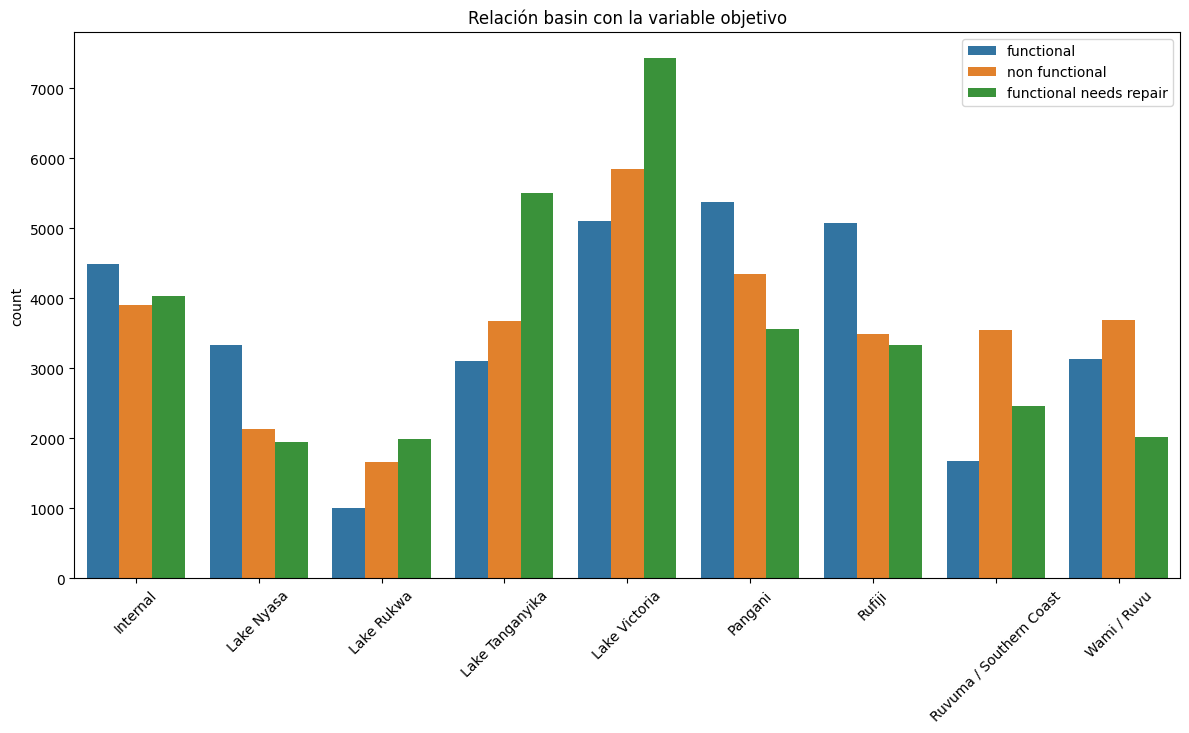

In [12]:
plt.rcParams['figure.figsize'] = [12, 6] 
ax = sns.countplot(data=df, x='basin', hue='status_group')#,stat="percent"

ax.set_xlabel('')  # optionally remove 'date' label, as it is clear from the ticklabels
plt.tight_layout()
plt.title("Relación basin con la variable objetivo")
plt.xticks(rotation=45)
plt.legend(loc= "upper right")
plt.show()

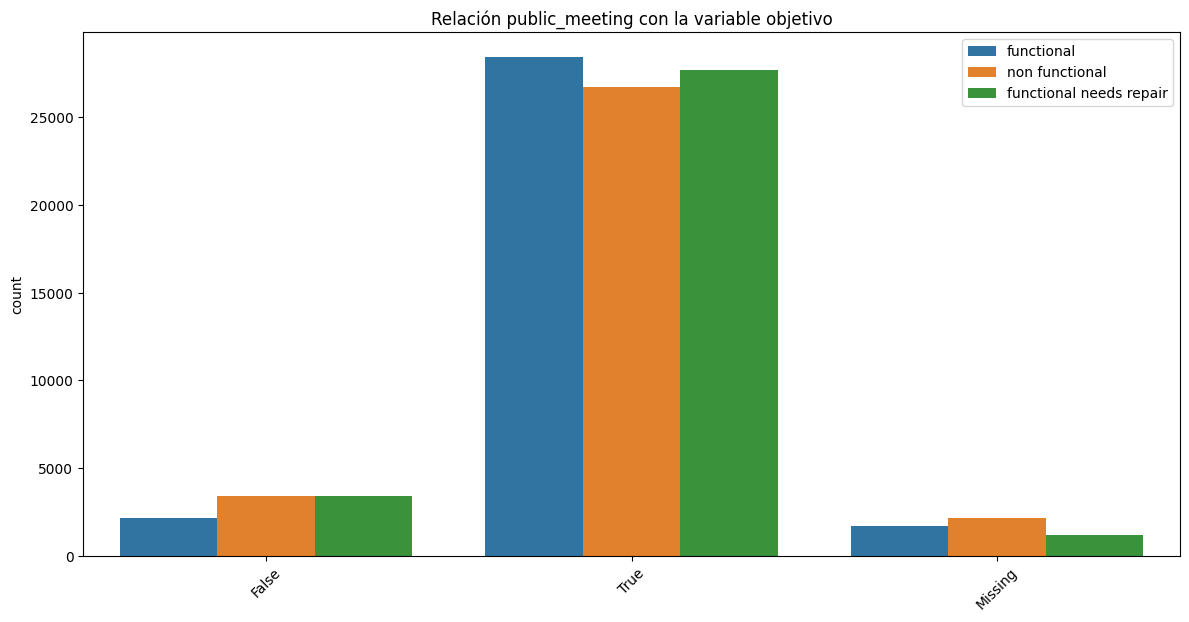

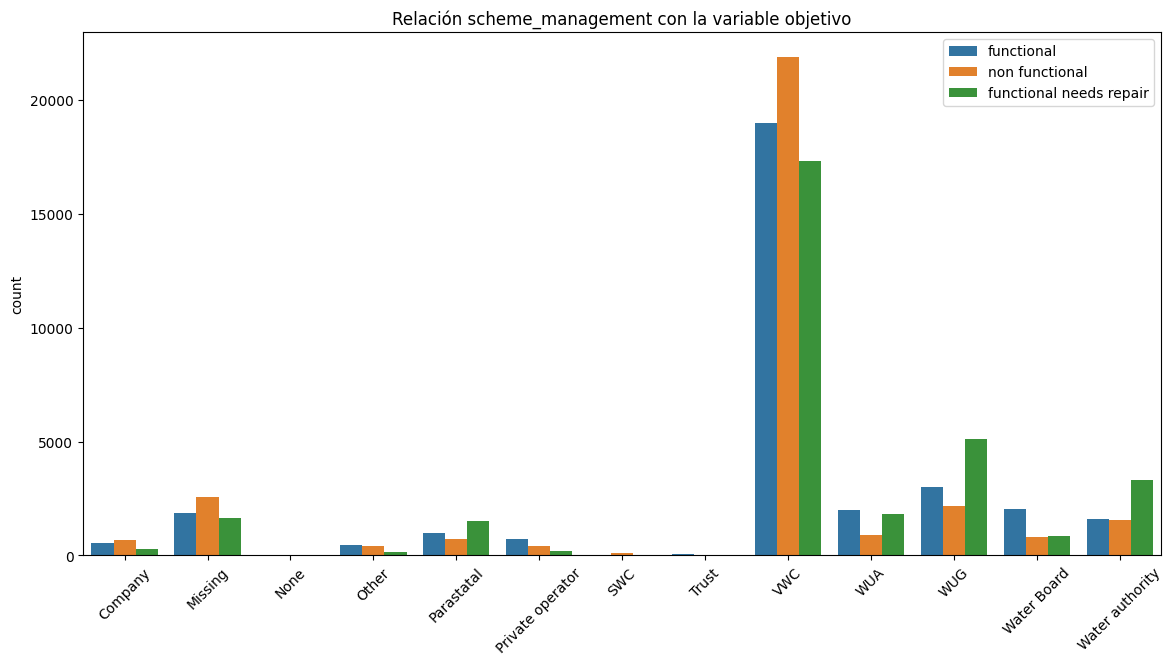

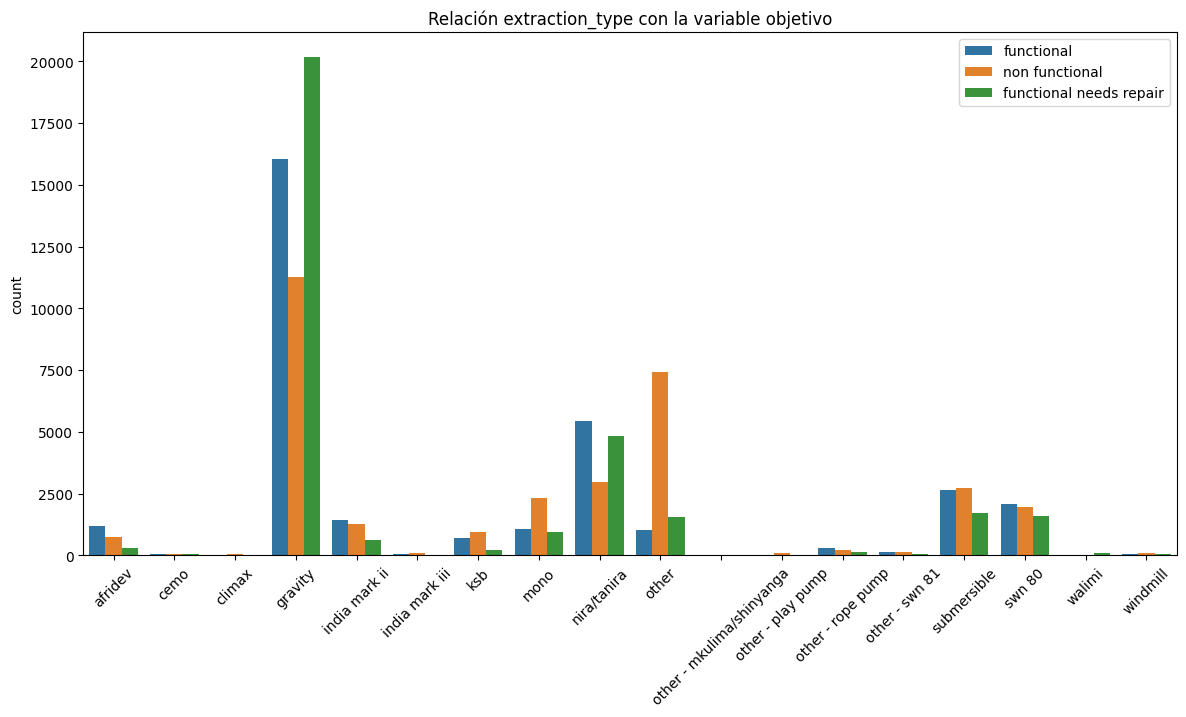

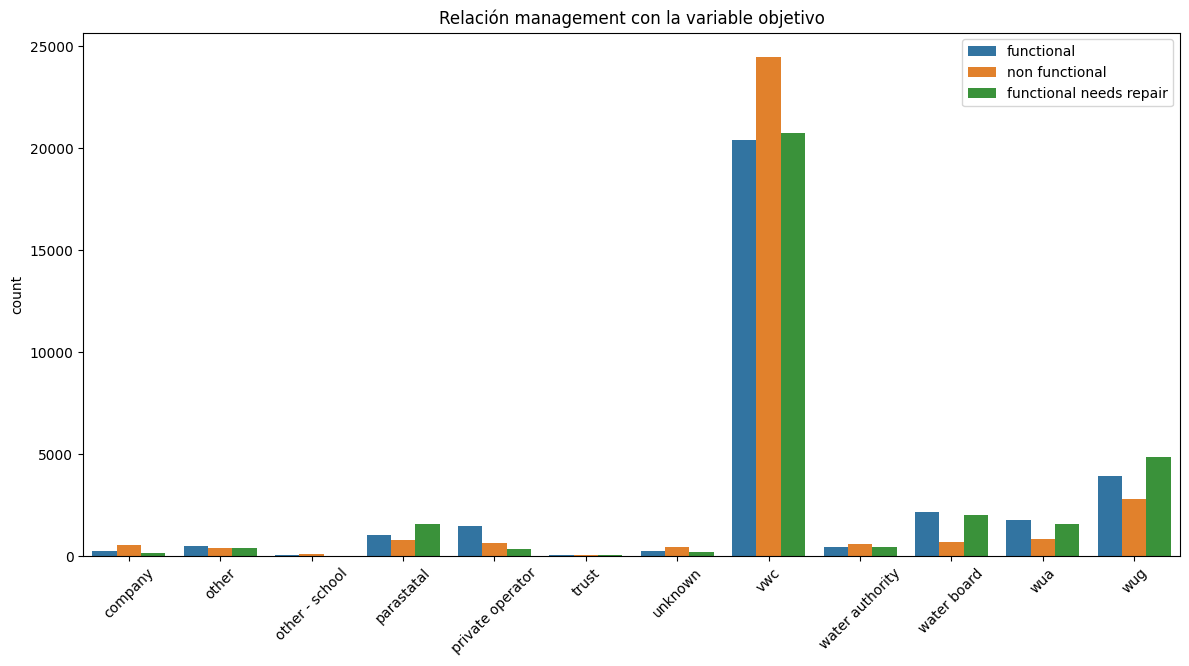

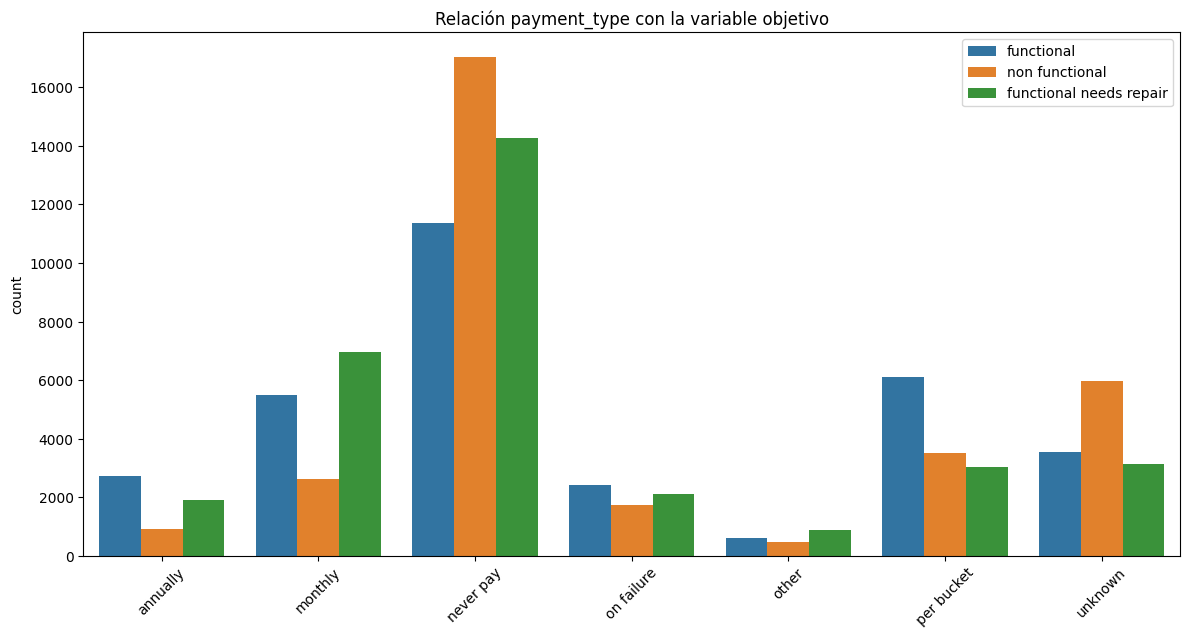

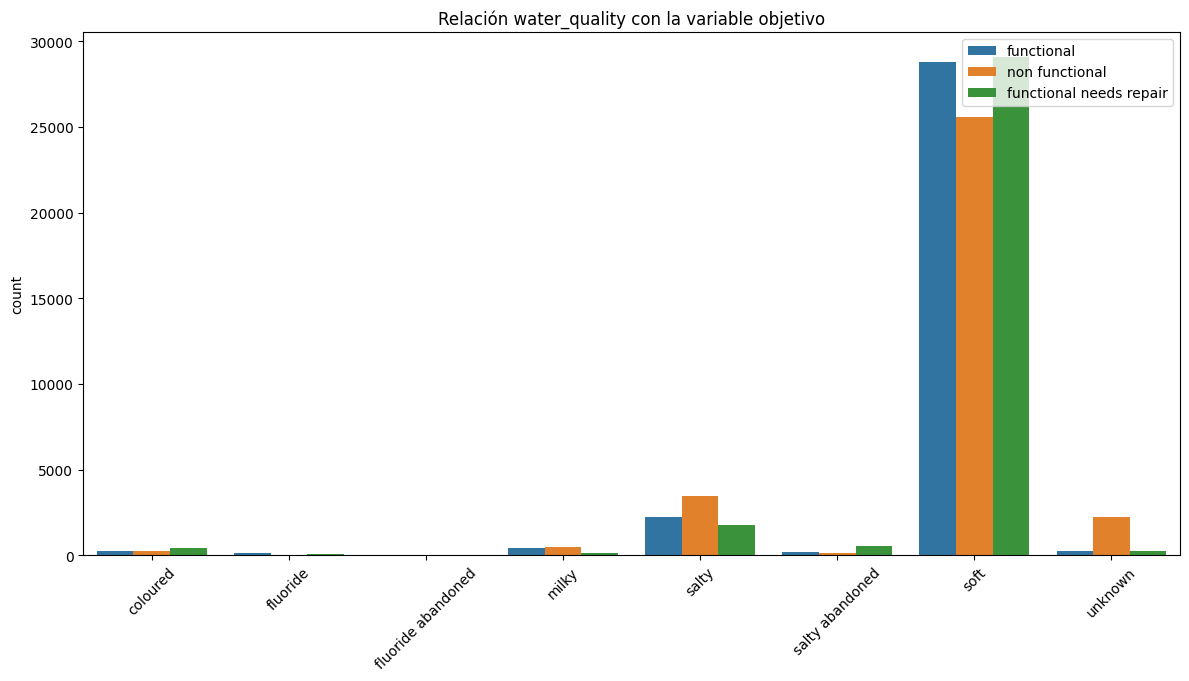

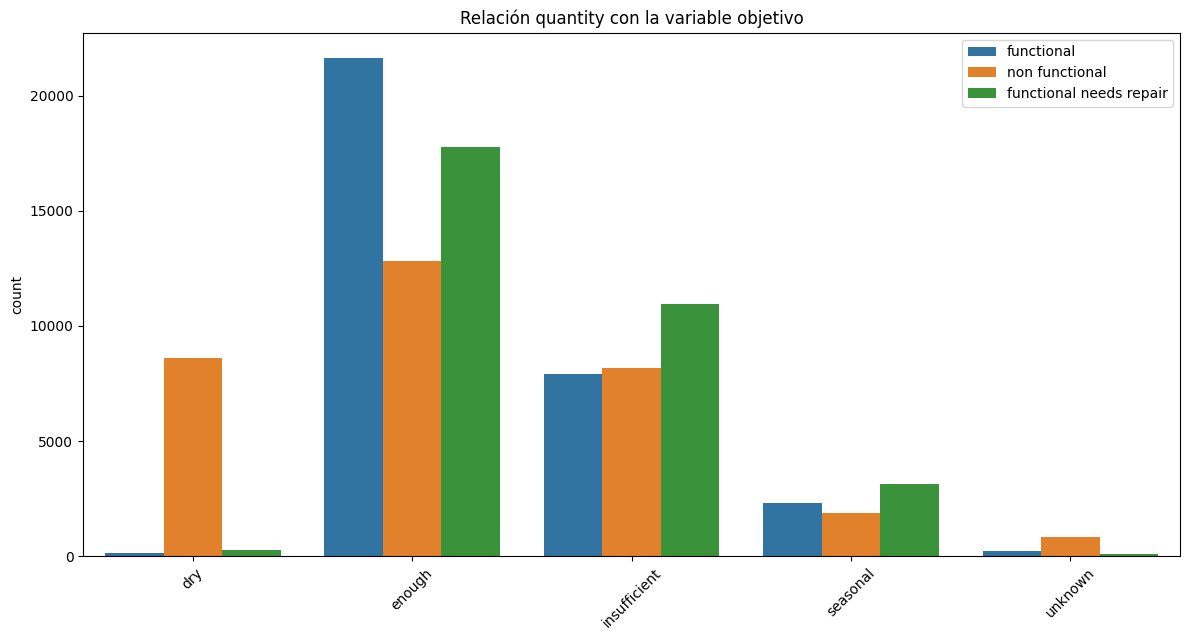

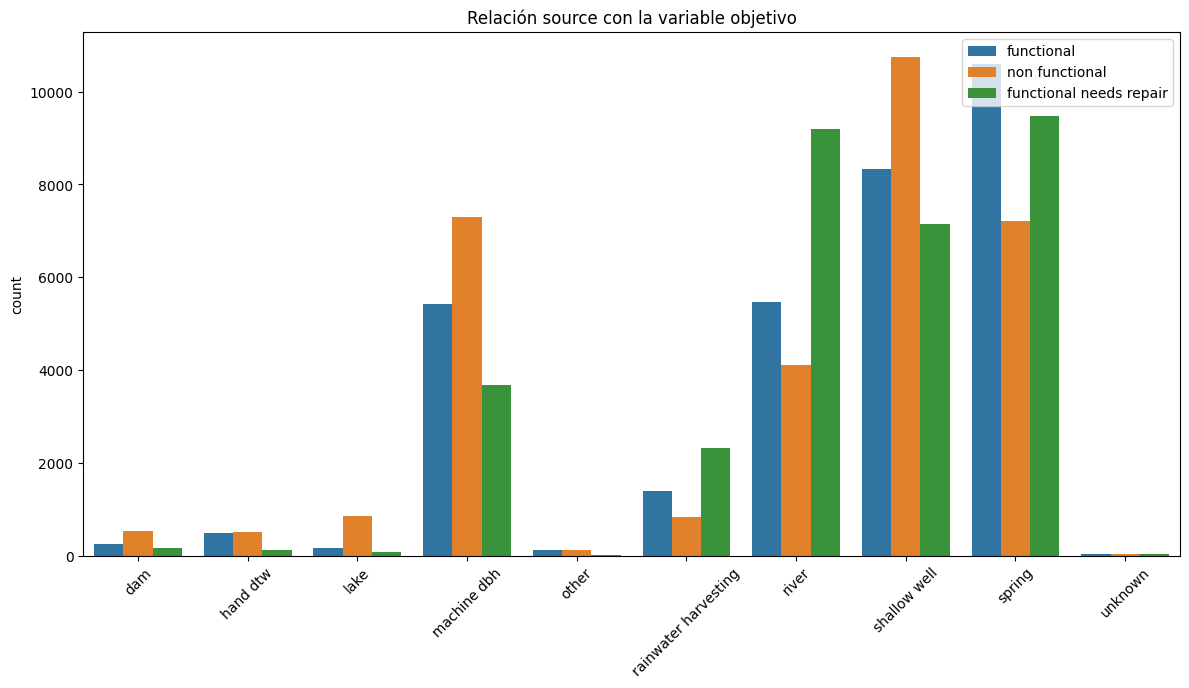

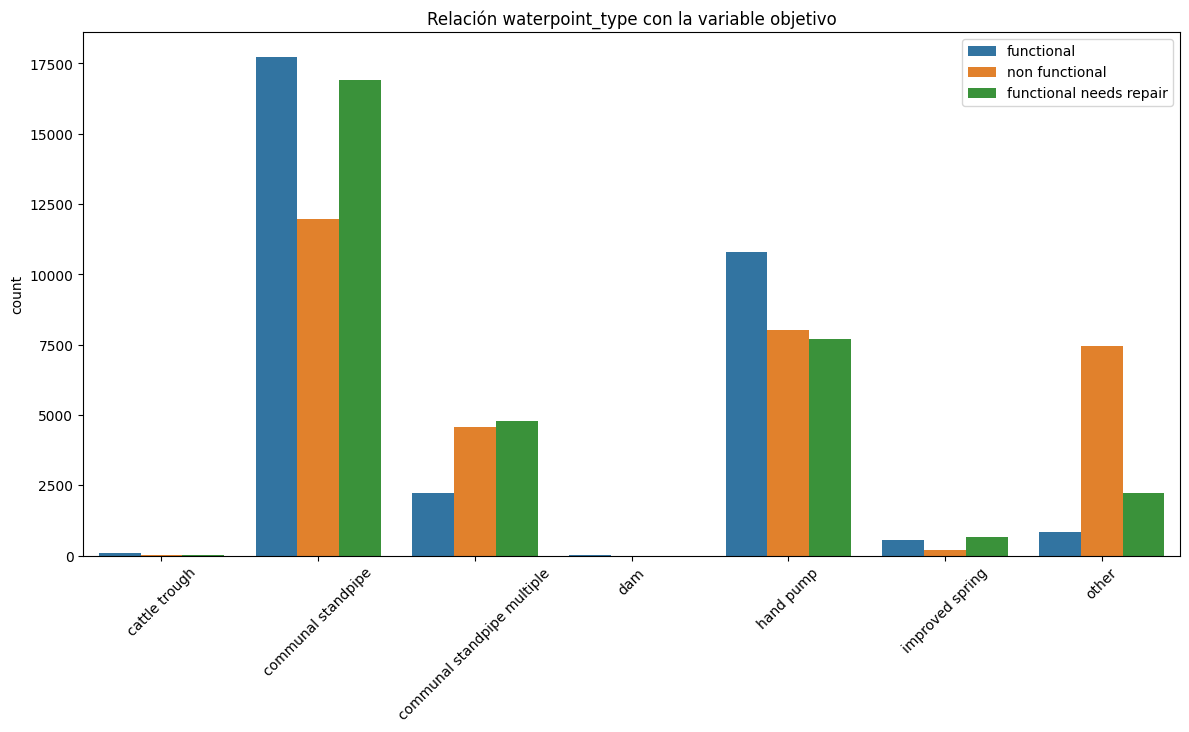

In [13]:
for col in X.select_dtypes(exclude=np.number).columns:
    if (X[col].nunique() < 25):
        if col!= "basin":
            ax = sns.countplot(data=df, x=col, hue='status_group')#,stat="percent"

            ax.set_xlabel('')  # optionally remove 'date' label, as it is clear from the ticklabels
            plt.title(f"Relación {col} con la variable objetivo")
            plt.tight_layout()
            plt.xticks(rotation=45)
            plt.legend(loc= "upper right")
            plt.show()
            

In [14]:
for col in df.select_dtypes(exclude=np.number).columns:
    if (df[col].nunique() > 25):
            print(df[col].value_counts() / len(df))
            print("--------------------------------------------------------------------------------")

Government Of Tanzania    0.160441
Missing                   0.072900
Danida                    0.048379
Hesawa                    0.042314
Dwsp                      0.024903
                            ...   
Mayiro                    0.000010
Matyenye                  0.000010
Matogoro                  0.000010
Matimbwa Sec              0.000010
Zingibali Secondary       0.000010
Name: funder, Length: 1898, dtype: float64
--------------------------------------------------------------------------------
DWE                         0.315726
Missing                     0.073323
Government                  0.040092
RWE                         0.024438
DANIDA                      0.018310
                              ...   
Makori                      0.000010
Makonde water Population    0.000010
Makala                      0.000010
Mahemba                     0.000010
world vision                0.000010
Name: installer, Length: 2146, dtype: float64
--------------------------------------

['Government Of Tanzania', 'Missing', 'Danida', 'Hesawa', 'Dwsp', 'Rwssp', 'World Bank', 'World Vision', 'Norad', 'Kkkt', 'Unicef', 'Tasaf', 'Dhv', 'District Council', 'Water', 'Lga', 'Isf', 'Private Individual', 'Tcrs', '0', 'Ministry Of Water', 'Dwe', 'Oxfam', 'Germany Republi', 'Fini Water', 'Adb', 'Netherlands', 'Rudep', 'Amref', 'Hifab']


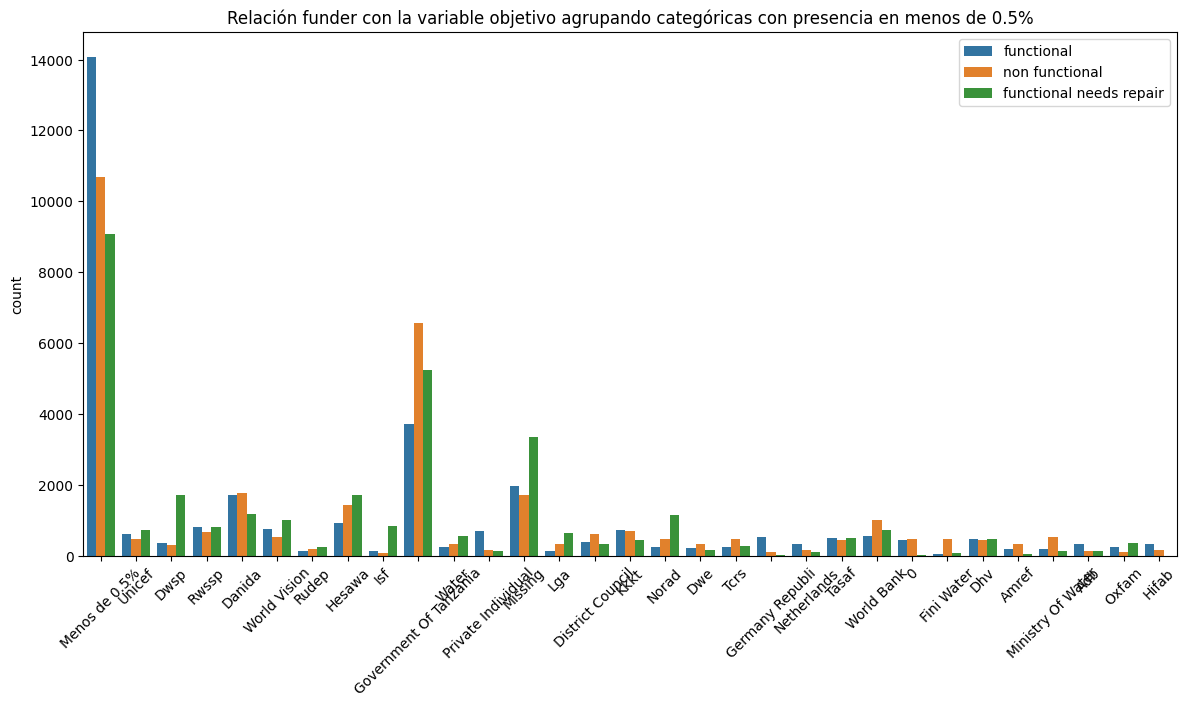

['DWE', 'Missing', 'Government', 'RWE', 'DANIDA', 'KKKT', 'Commu', 'TCRS', 'Hesawa', 'LGA', '0', 'District Council', 'Central government', 'HESAWA', 'Community', 'World vision', 'Gover', 'CES', 'DANID', 'TASAF', 'District council', 'TWESA', 'WEDECO', 'OXFAM', 'World Vision', 'NORAD']


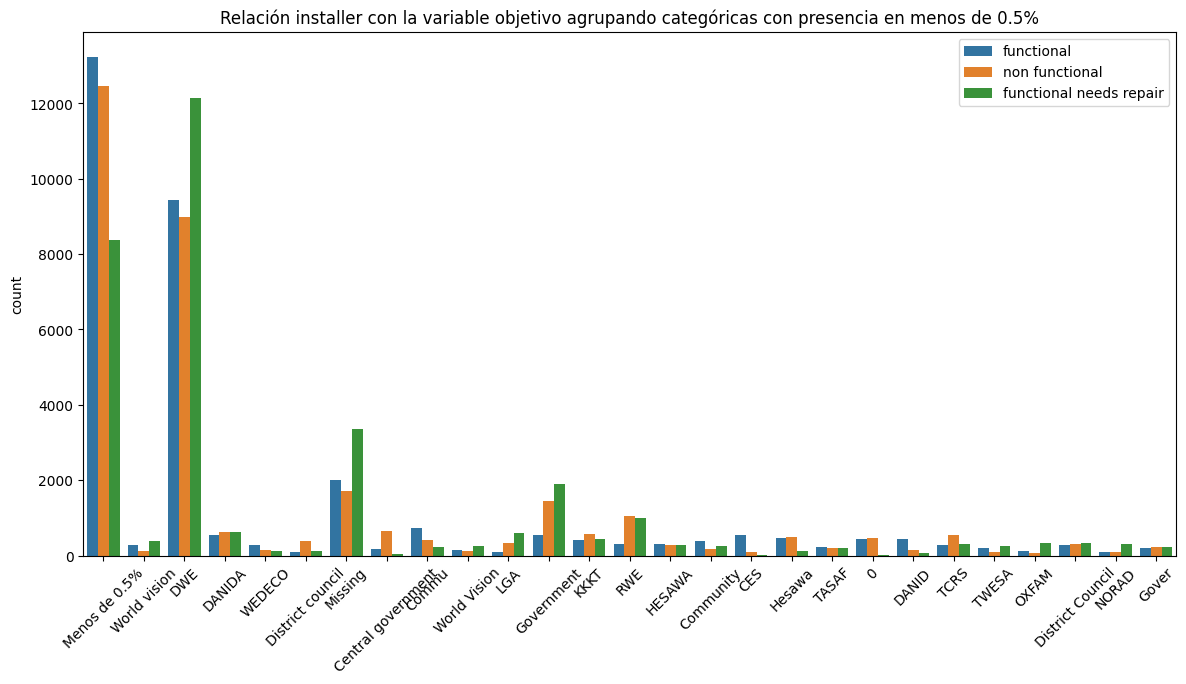

['none', 'Shuleni', 'Zahanati', 'Msikitini', 'Kanisani', 'Sokoni']


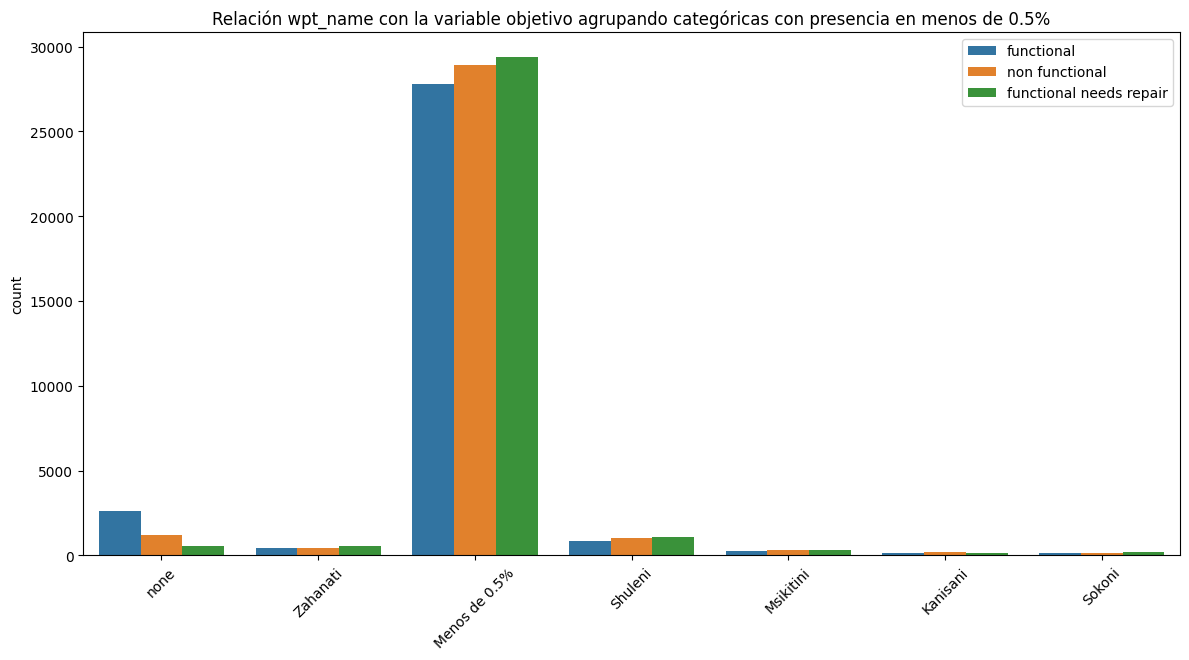

['Madukani', 'Shuleni', 'Majengo', 'Kati']


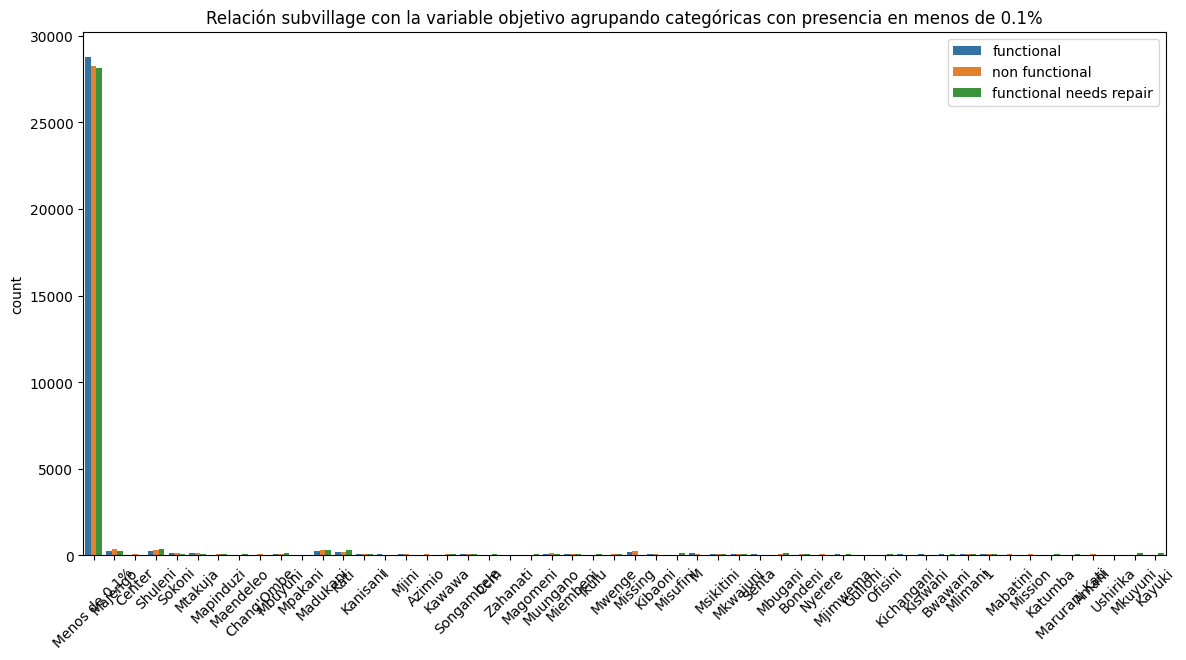

['Bariadi', 'Njombe', 'Kigoma Rural', 'Kasulu', 'Rungwe', 'Moshi Rural', 'Same', 'Kilosa', 'Arusha Rural', 'Mbozi', 'Kilombero', 'Mbarali', 'Singida Rural', 'Magu', 'Kibondo', 'Mpanda', 'Meru', 'Ngara', 'Maswa', 'Kondoa', 'Mbinga', 'Mvomero', 'Karagwe', 'Bukoba Rural', 'Lushoto', 'Masasi', 'Kyela', 'Bagamoyo', 'Songea Rural', 'Kahama', 'Ulanga', 'Serengeti', 'Chunya', 'Morogoro Rural', 'Namtumbo', 'Mwanga', 'Bukombe', 'Ukerewe', 'Babati', 'Iramba', 'Iringa Rural', 'Rombo', 'Meatu', 'Tunduru', 'Sumbawanga Rural', 'Kwimba', 'Mbeya Rural', 'Kishapu', 'Shinyanga Rural', 'Nzega', 'Mkuranga', 'Mpwapwa', 'Kilwa', 'Hai', 'Nkasi', 'Dodoma Urban', 'Ludewa', 'Geita', 'Musoma Rural', 'Makete', 'Lindi Rural', 'Mufindi', 'Chamwino', 'Bunda', 'Rufiji', 'Mtwara Rural', 'Ilala', 'Biharamulo', 'Urambo', 'Misenyi', 'Muleba', 'Longido', 'Ruangwa', 'Manyoni', 'Korogwe', 'Newala', 'Igunga', 'Nachingwea']


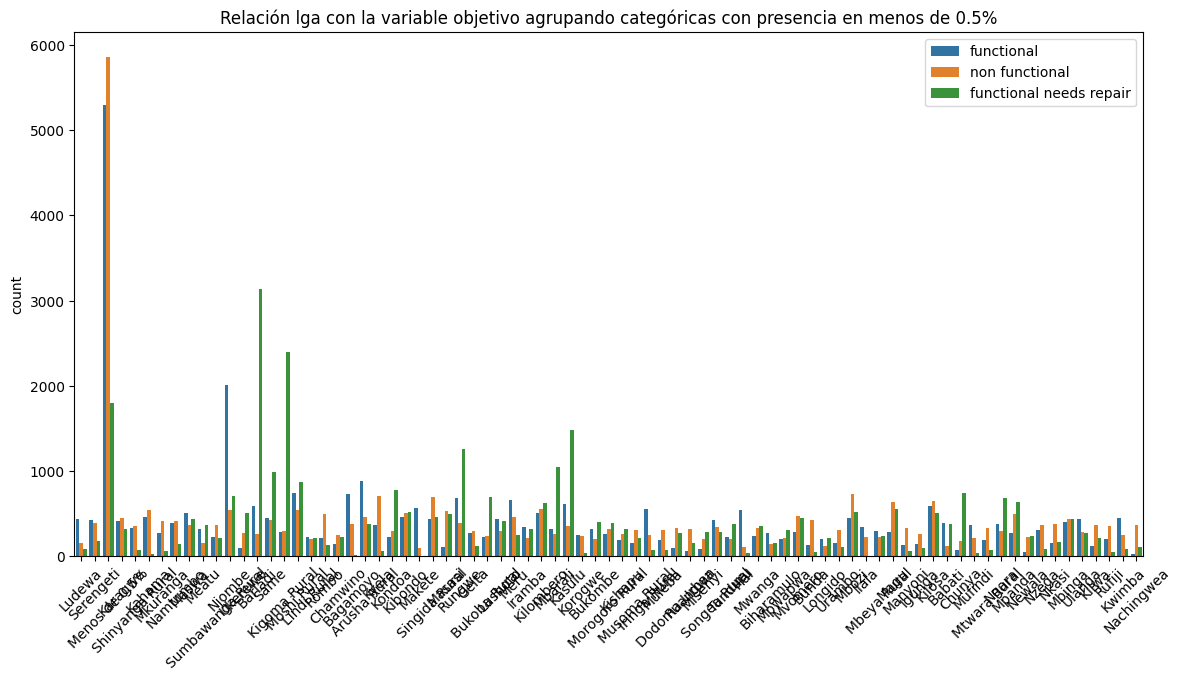

['Nkoma']


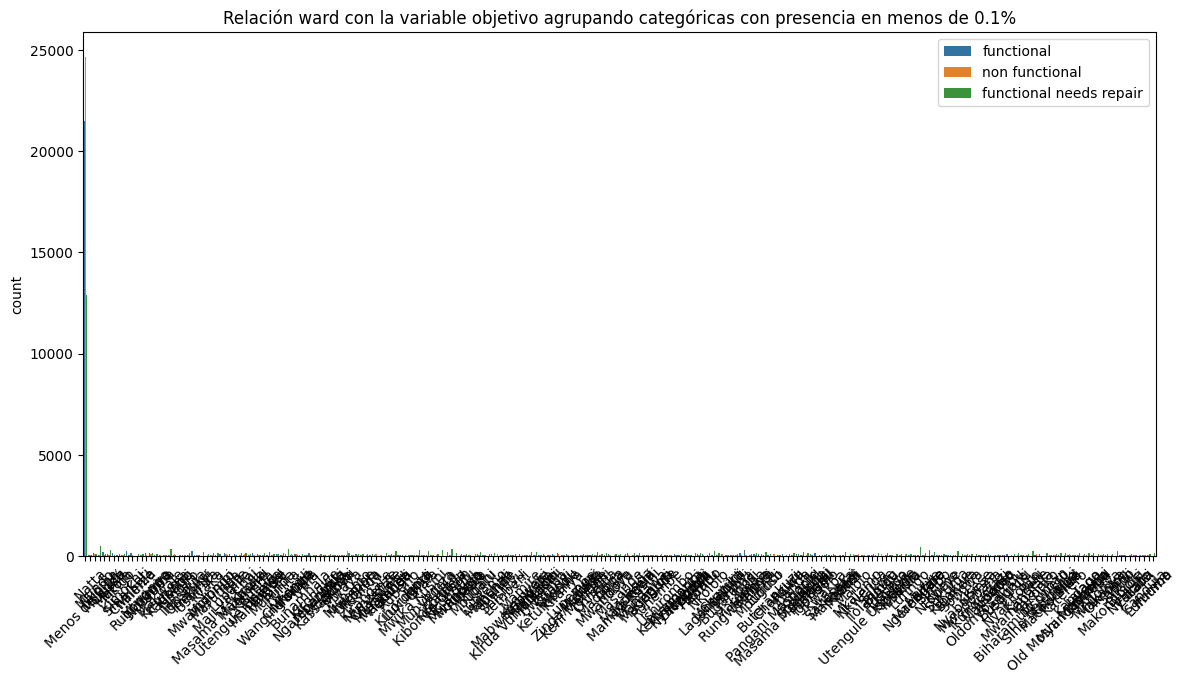

['Missing', 'K', 'None', 'Borehole', 'M', 'Mkongoro Two', "wanging'ombe water supply s", 'Government', 'Mkongoro One', 'DANIDA']


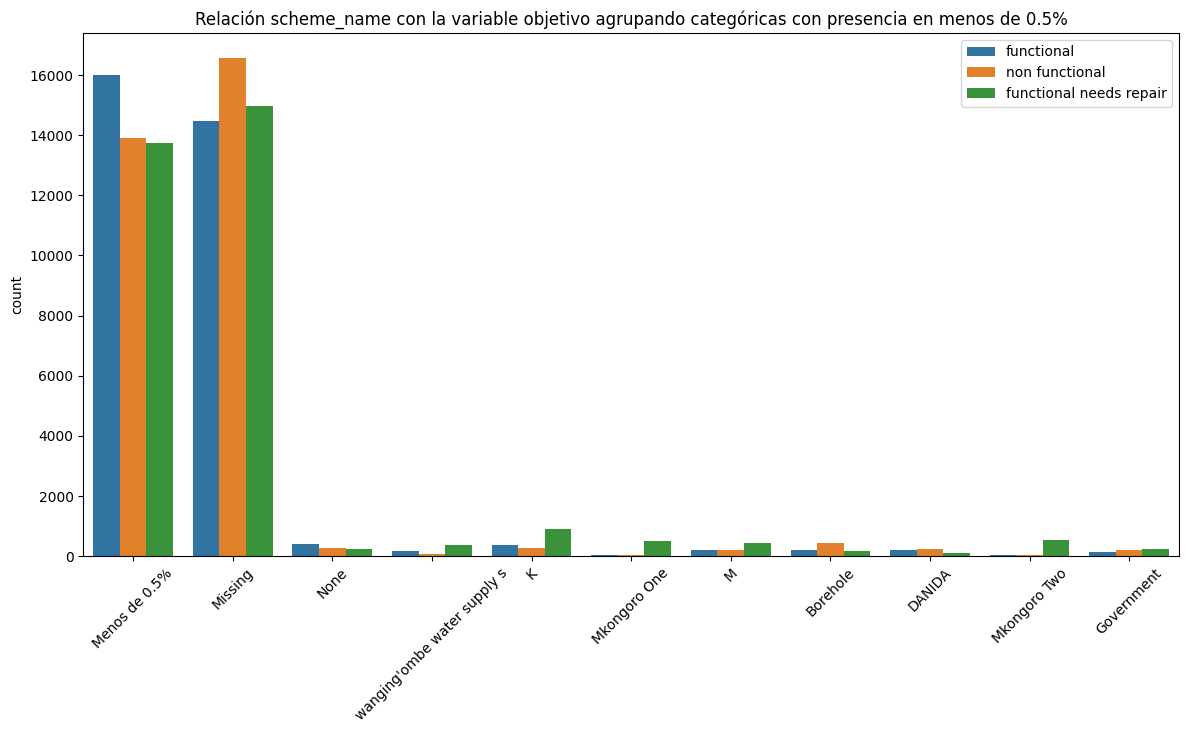

In [15]:
def find_frequent_labels(df, variable, tolerance):
               temp = df[variable].value_counts()  / len(df)
               frequent = [x for x in temp.loc[temp>tolerance].index.values]
               return frequent


for col in df.select_dtypes(exclude=np.number).columns:
    if (df[col].nunique() > 25):
            frequent_cat = find_frequent_labels(df, col, 0.005)
            print(frequent_cat)
            if len(frequent_cat) > 5:
                df[col] = np.where(df[col].isin(frequent_cat), df[col], 'Menos de 0.5%')
                ax = sns.countplot(data=df, x=col, hue='status_group')#,stat="percent"

                ax.set_xlabel('')  # optionally remove 'date' label, as it is clear from the ticklabels
                plt.title(f"Relación {col} con la variable objetivo agrupando categóricas con presencia en menos de 0.5%")
                plt.tight_layout()
                plt.xticks(rotation=45)
                plt.legend(loc= "upper right")
                plt.show()
            else:
                frequent_cat = find_frequent_labels(df, col, 0.001)
                df[col] = np.where(df[col].isin(frequent_cat), df[col], 'Menos de 0,1%')
                ax = sns.countplot(data=df, x=col, hue='status_group')#,stat="percent"

                ax.set_xlabel('')  # optionally remove 'date' label, as it is clear from the ticklabels
                plt.title(f"Relación {col} con la variable objetivo agrupando categóricas con presencia en menos de 0.1%")
                plt.tight_layout()
                plt.xticks(rotation=45)
                plt.legend(loc= "upper right")
                plt.show()
        

In [16]:
for col in df.select_dtypes(include=np.number).columns:
        print(col)

date_recorded
gps_height
longitude
latitude
district_code
construction_year


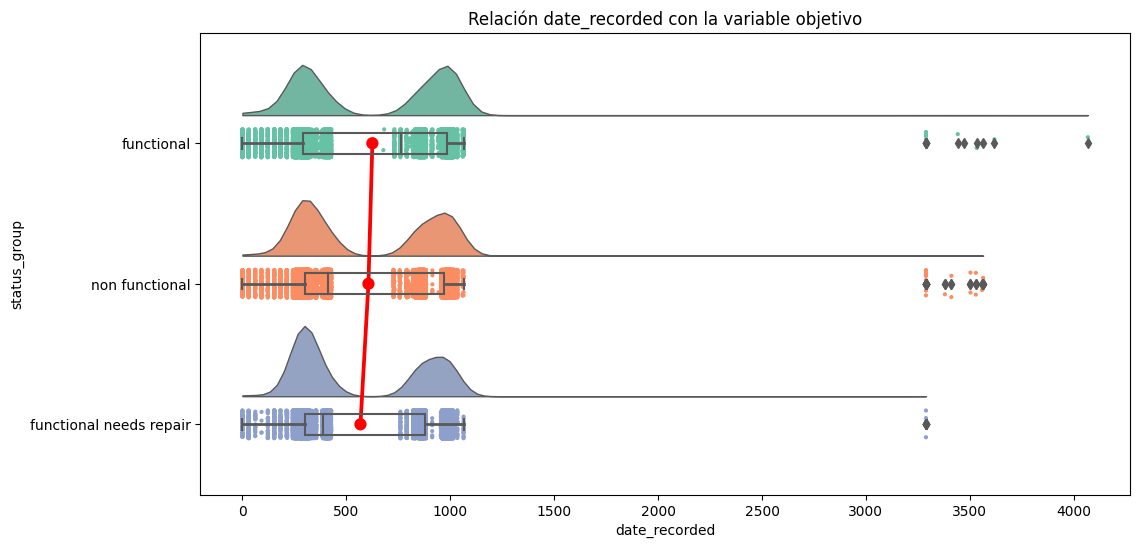

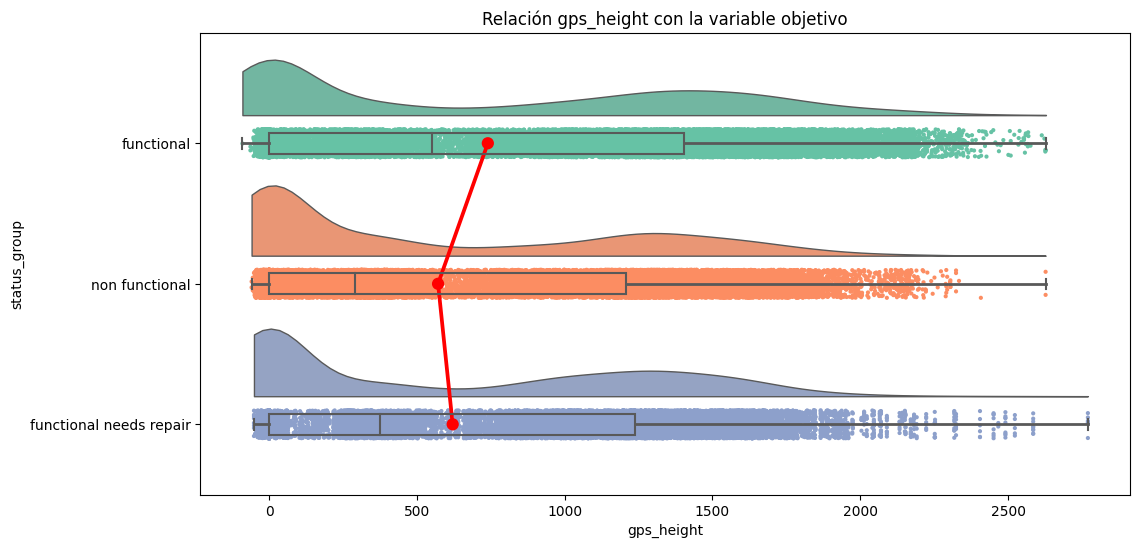

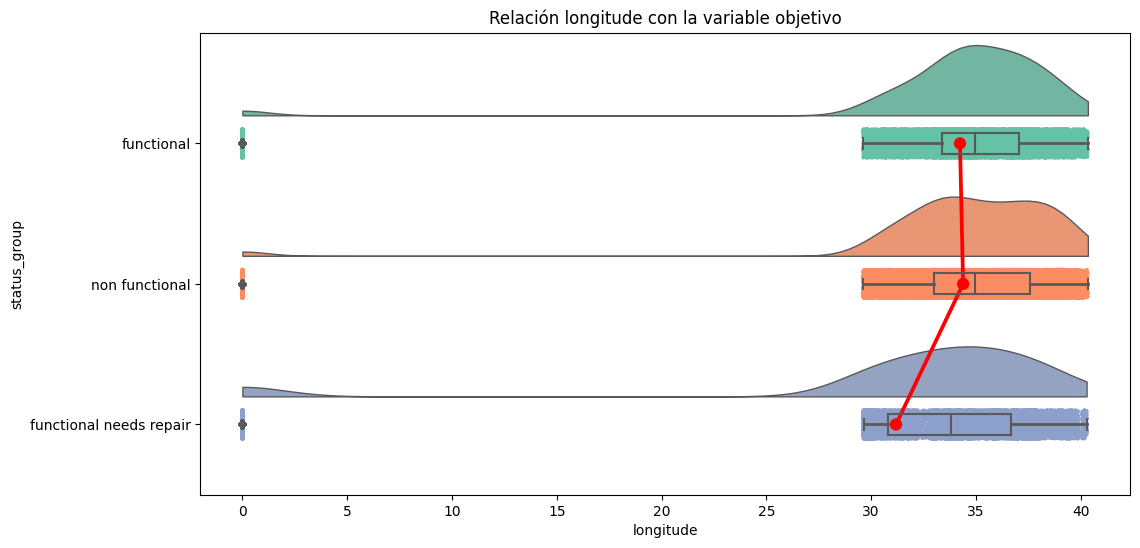

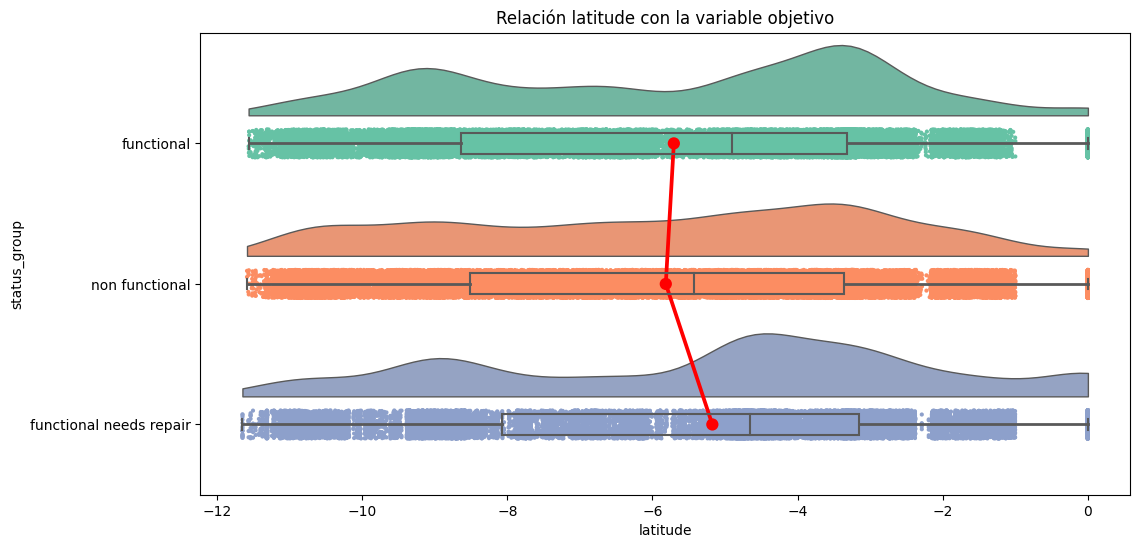

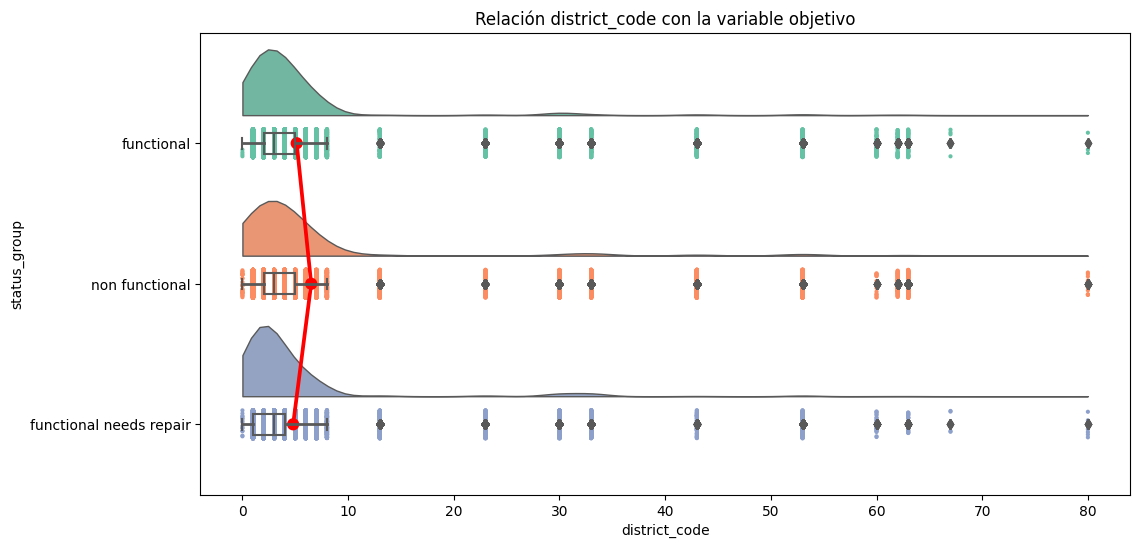

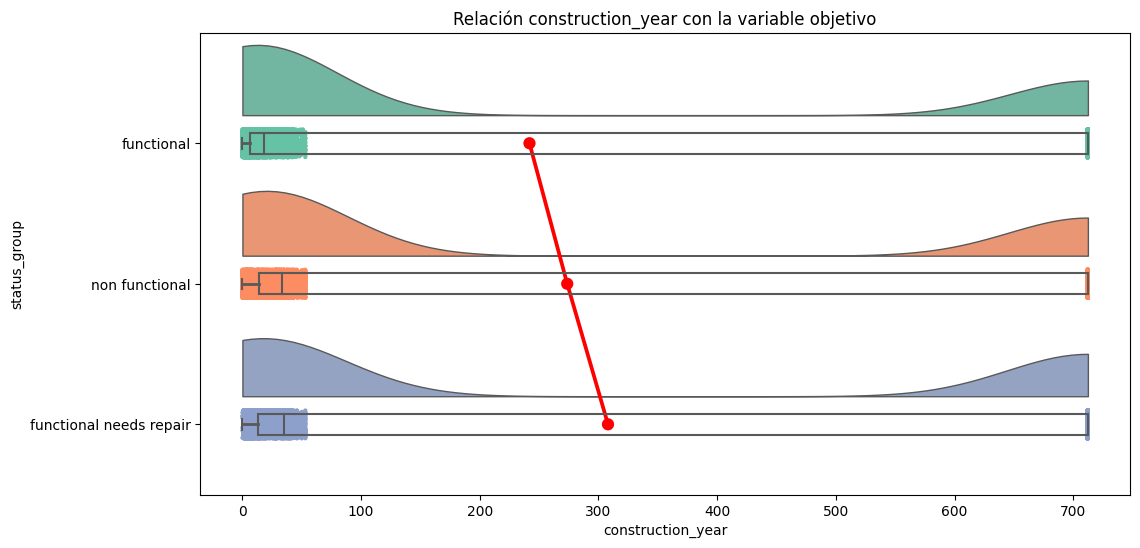

In [17]:
for col in df.select_dtypes(include=np.number).columns:
        pt.RainCloud(x = "status_group", y = col, data = df,width_viol = 1,orient = "h",pointplot=True)
        plt.title(f"Relación {col} con la variable objetivo")
        plt.show()

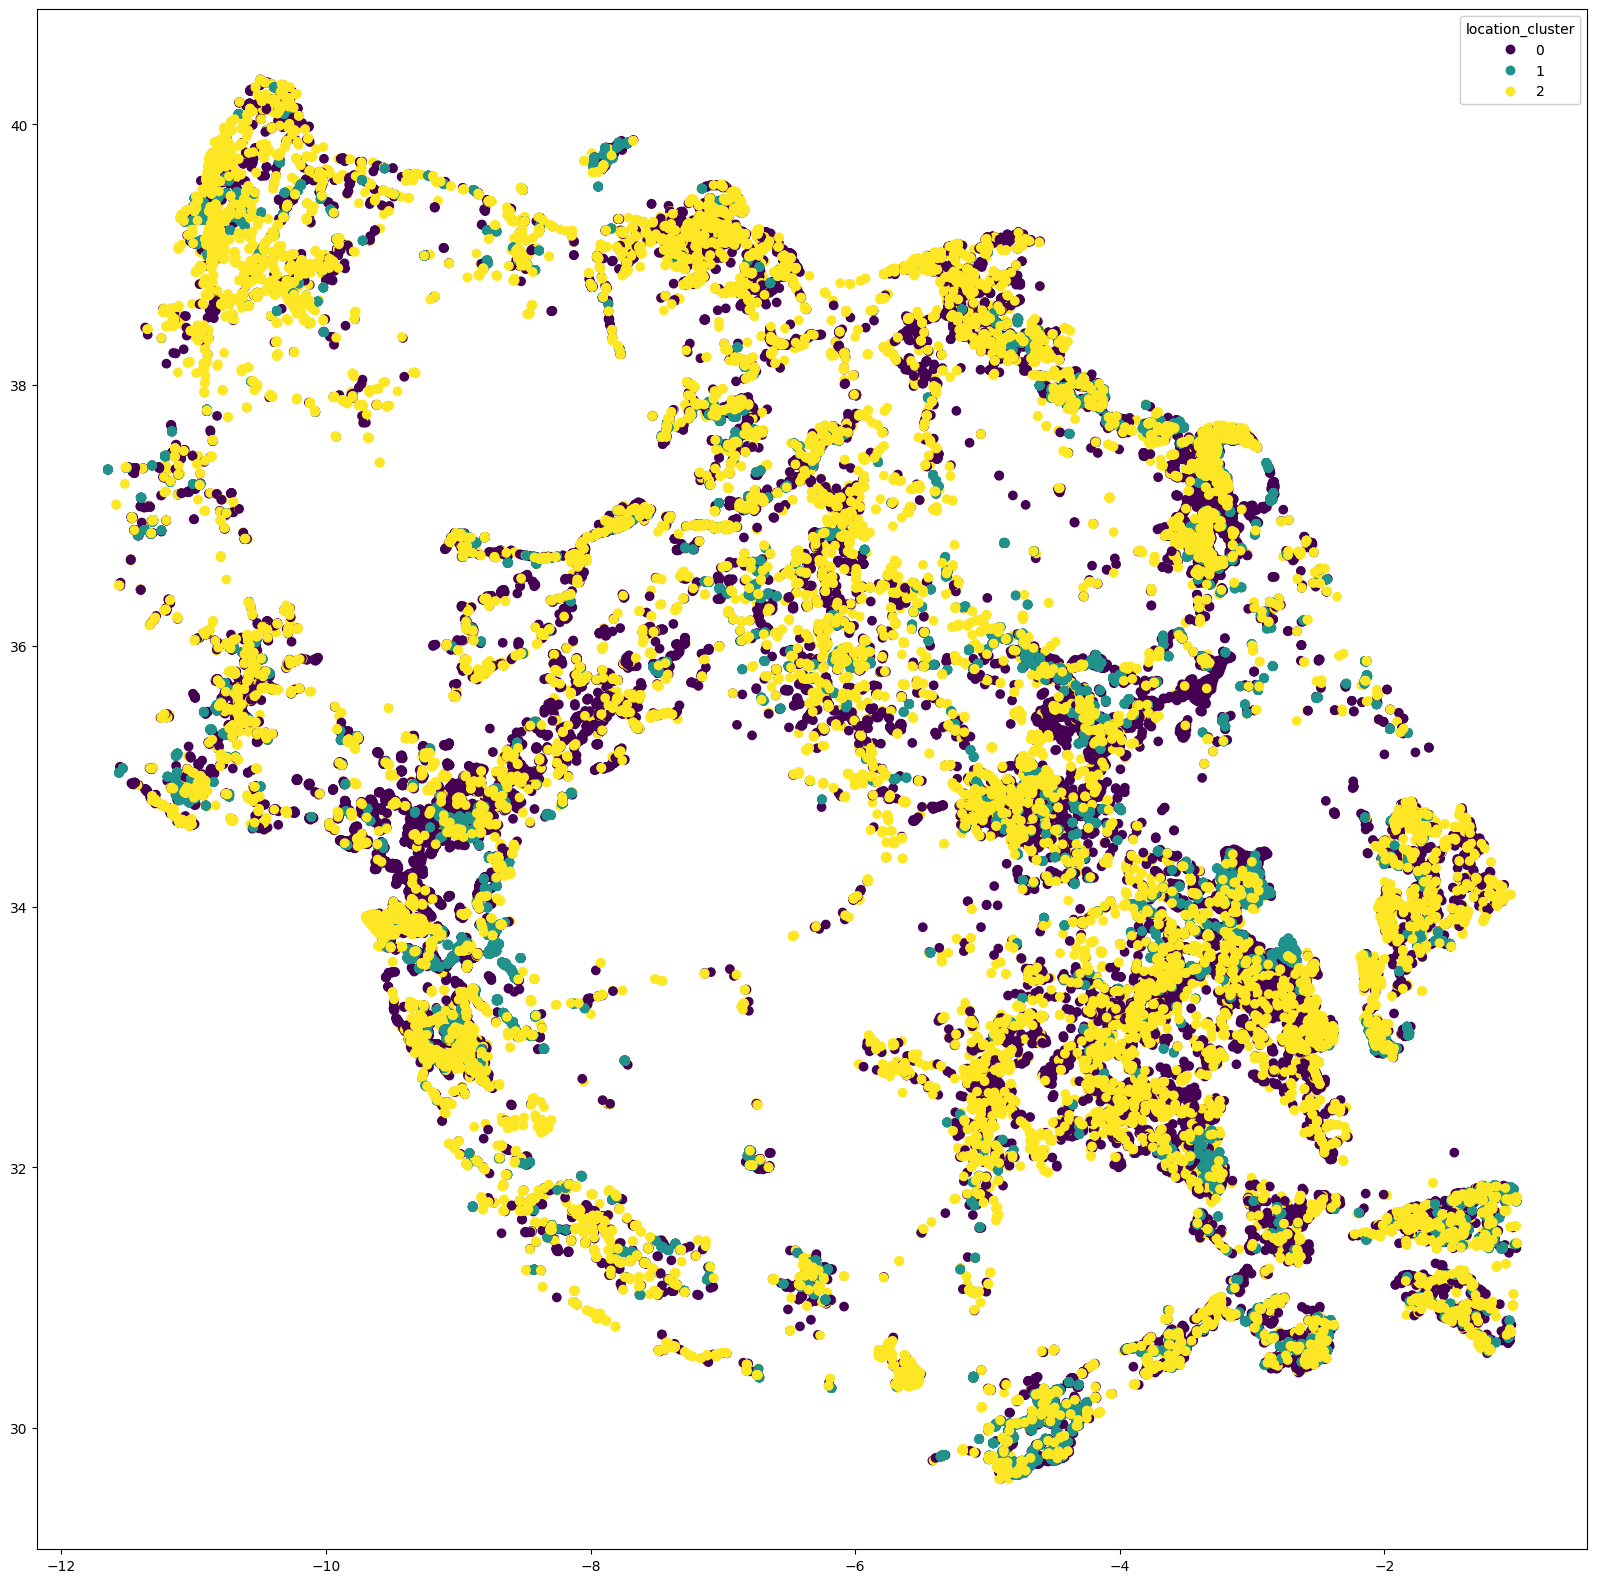

In [18]:
df_geo = df[["latitude","longitude","status_group"]].copy()
df_geo = df_geo.loc[(df_geo["latitude"]!=0)&(df_geo["longitude"]!=0)]

fig,ax = plt.subplots(figsize=(20,20))
df_geo["status_group_num"]=LabelEncoder().fit_transform(df_geo.status_group)


scatter = ax.scatter(data=df_geo,x="latitude",y="longitude",c="status_group_num")

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="location_cluster")
ax.add_artist(legend1)
plt.show()
